In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import haversine as hs
import geopandas as gp
from shapely.geometry import Point, Polygon
import numpy as np

from pyomo.environ import Var, Expression, NonNegativeReals, Block, ConcreteModel, Constraint, Objective, Param, maximize, SolverFactory,RangeSet
import pyomo.environ as pyo
from idaes.core import FlowsheetBlock
from pyomo.environ import Block, Expression, units as pyunits
import math
from watertap3.utils import watertap_setup, get_case_study, run_model 
from watertap3.utils import run_watertap3, run_model_no_print, run_and_return_model
from truck_pipe_cost_functions import truck_costing, pipe_costing
from bw_lcow_functions import *
import os

Updated brackish water LCOW calculations

In [2]:
# bw_df = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Brackish/brackish_sites_with_metrics_baseline_dwi_updated_costs_transport_updated_basis_1.csv')
bw_df = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Brackish/brackish_sites_baseline_dwi_5Feb23.csv')
netl_df = pd.read_csv("/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Power/NETL_ThermalPlants_Filtered.csv")
pp_elev_db = pd.read_csv("/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Power/pp_elevation_data.csv", index_col = 0)
pp_elev_db = pp_elev_db.set_index('PlantCode')

state_alpha = 'AZ'
# PATH = r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Brackish\clustering_results\\' + state_alpha
PATH = r'\Users\mhardika\Documents\AMO\Analysis Data Files\clustering_results\\' + state_alpha
cluster_bw_df = pd.read_csv(PATH + '\\' + state_alpha.lower()+'_cluster.csv').drop(['Unnamed: 0'],axis=1)
subcluster_bw_df = pd.read_csv(PATH + '\\' + state_alpha.lower()+'_subcluster.csv').drop(['Unnamed: 0'],axis=1)
bw_cluster_kmeans = pd.read_csv(PATH + '\\' + state_alpha.lower()+'_bw_kmeans.csv').drop(['Unnamed: 0'],axis=1)

us_counties = gp.read_file(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\GeoData\US_County_Boundaries\US_CountyBndrys.shp')
us_counties = us_counties.to_crs("EPSG:4326")
us_states = gp.read_file(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files\tl_rd22_us_state\tl_rd22_us_state.shp')

state_code_df =  pd.read_csv(r'/Users/mhardika/Documents/watertap3/WaterTAP3/watertap3/watertap3/data/state_geocode.csv',index_col='abbv')


In [3]:
# Combine the demand for powerplant independent of of energy source
pp_df = netl_df[((netl_df.WaterType == 'Fresh') & (netl_df.WAvg != '...') & (netl_df.WAvg != '---'))]
pp_group= pp_df.groupby('PlantCode')
pp_df.WAvg = pp_df.WAvg.astype(float)  #Gal/MWh
cols= ['PlantCode','Demand_m3/s','PPLatitude','PPLongitude']

pp_combined_df = pd.DataFrame(columns = cols)
pp_group= pp_df.groupby('PlantCode')

for key in pp_group.groups.keys():

    demand = sum((pp_group.get_group(key).WAvg * 0.0037854 / 3600) * pp_group.get_group(key).Capacity)  # Capacity in MW
    # pp_combined_df = pp_combined_df.append
    temp_dict = {'PlantCode':key,
                 'PlantState':pp_group.get_group(key)['PlantState'].values[0],
                 'Demand_m3/s': demand ,
                 'PPLatitude':pp_group.get_group(key)['Latitude'].values[0],
                 'PPLongitude':pp_group.get_group(key)['Longitude'].values[0]
                 }
    
    temp = pd.DataFrame(temp_dict,index= [0])                  
    pp_combined_df = pd.concat([pp_combined_df,temp],ignore_index=True)
    pp_combined_df.reset_index()


Updating powerplant dataframe to group demand with the same plant code (independent of fuel)\
Filter powerplants where freshwater is used and where all the data is available --> this filter is copied from previous files

In [4]:
# pp_combined_df.to_csv(r'\Users\mhardika\Documents\AMO\Analysis Data Files\Power\power_plant_combined_demand.csv')

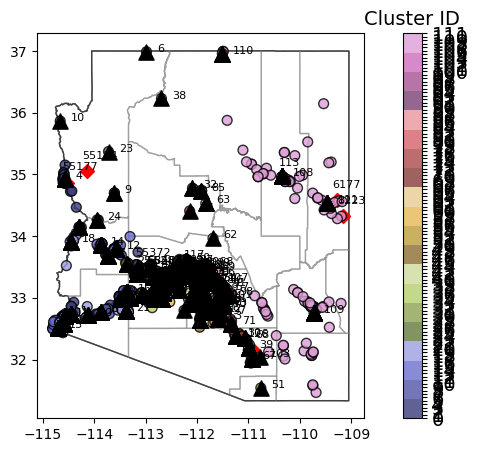

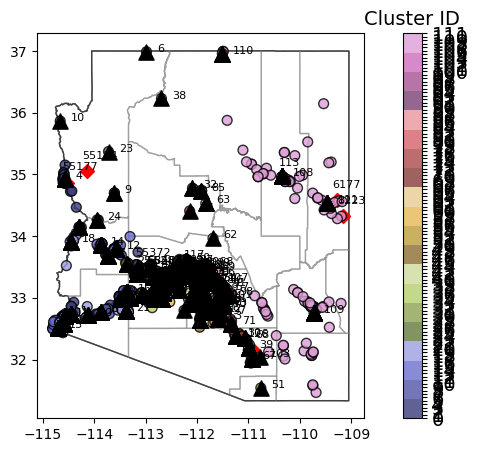

In [5]:
# Plot location of powerplants
# pp_demand_met_df = one_pp_many_bw_df.groupby('PlantCode').last()

def plot_map(cluster_bw_df):
    abbv_code = cluster_bw_df.state_alpha.map(state_code_df.state_id)

    state_code = f'{abbv_code[0]:02d}'
    # state_code = '09'
    state_geo = us_counties.loc[us_counties['STATEFP']==state_code]
    state_border = us_states.loc[us_states['STATEFP']==state_code]

    pp_long = pp_combined_df[pp_combined_df['PlantState']==state_alpha]['PPLongitude']
    pp_lat = pp_combined_df[pp_combined_df['PlantState']==state_alpha]['PPLatitude']

    pp_geometry = [Point(xy) for xy in zip(pp_long,pp_lat)]
    pp_geo_df = gp.GeoDataFrame(geometry = pp_geometry, crs='EPSG:4326')
    pp_geo_df.geometry = pp_geo_df.geometry.to_crs('EPSG:4326')

    # pp_demand_met_df = one_pp_many_bw_df[one_pp_many_bw_df['Cum_PPDemandFracMet']>=1].groupby('PlantCode').first()

    fig, (ax) = plt.subplots(figsize = (10,5))

    state_border.plot(ax=ax,facecolor ='none',edgecolor ='black')
    state_geo.plot(ax=ax,facecolor ='none',edgecolor ='gray',alpha = 0.5)

    pp_geo_df.plot(ax=ax, color='red', markersize = 50,label='PP', marker = 'D')

    for i, txt in enumerate(pp_combined_df[pp_combined_df['PlantState']==state_alpha]['PlantCode'].unique()):
        ax.annotate(txt, 
                    (pp_combined_df[pp_combined_df['PlantCode']==txt]['PPLongitude'].values[0]-0.1, 
                    pp_combined_df[pp_combined_df['PlantCode']==txt]['PPLatitude'].values[0]+0.2),fontsize =8)

    # Plot subcluster and cluster centroids
    state_df = bw_cluster_kmeans
    cm = plt.cm.get_cmap('tab20b')

    sc = ax.scatter(x = state_df['Longitude'], y = state_df['Latitude'], s=50, 
                    c=state_df['cluster_id'].values, cmap=cm, edgecolor ='black',alpha = 0.8)

    for cluster in state_df['cluster_id'].unique():
        df_0 = state_df[(state_df['cluster_id']==cluster)]
        
        # Plot the centroid in each cluster
        ax.scatter(df_0['centroid_long'], df_0['centroid_lat'], c='black', s=120, marker = '^',edgecolor ='black')
        ax.annotate(cluster, (df_0['centroid_long'].values[0]+0.2, df_0['centroid_lat'].values[0]),fontsize =8)

    if len(state_df['cluster_id'].unique())%2 == 0:
        ticks_var = len(state_df['cluster_id'].unique()) 
    else:
        ticks_var = len(state_df['cluster_id'].unique()) + 1

    cbar = plt.colorbar(sc,ax=ax,ticks = plt.MaxNLocator(ticks_var))
    cbar.ax.set_title('Cluster ID',fontsize = 14)
    cbar.ax.tick_params(labelsize=14)
    plt.ioff()
    return fig

plot_map(cluster_bw_df)

In [6]:
# Function to build bw and PP supply table without clustering
# Selects wells in increase order increasing total cost of supply (treatment + transport)
def state_pp_calc(state_code):
    
    # Get state sub-dataframe
    bw_state_df = bw_df[bw_df['state_alpha']==state_code]
    bw_state_df = bw_state_df.set_index('unique_site_ID')

    pp_state_df =  pp_combined_df[pp_combined_df['PlantState']==state_code]
    pp_state_df = pp_state_df.set_index('PlantCode')

    cols = ['State','PlantCode','PPLatitude','PPLongitude','PPDemand','BWSites','BWLatitude','BWLongitude','BWAvailable','Distance_km',
        'PPDemandFracMet','LCOW','TransportLCOW','tLCOW','WeightedtLCOW','Cum_PPDemandFracMet']

    one_pp_many_bw_df  = pd.DataFrame(columns=cols)

    for pp in pp_state_df.index:
        pp_long = pp_state_df['PPLongitude'].loc[pp]
        pp_lat = pp_state_df['PPLatitude'].loc[pp]
        pp_elev = pp_elev_db.loc[pp].values[0]
        # try:
        #     pp_elev = elevation(pp_lat,pp_long)
        # except:
        #     print(pp)
        #     pp_elev =0
        pp_loc = (pp_lat,pp_long)    

        plantcode = pp
        
        for site in bw_state_df.index:
            bw_long = bw_state_df['Longitude'].loc[site]
            bw_lat = bw_state_df['Latitude'].loc[site]
            bw_elev = bw_cluster_kmeans[bw_cluster_kmeans['unique_site_ID']==site]['well_elevation'].values[0]
            bw_loc = (bw_lat,bw_long)
            dist_km = hs.haversine(pp_loc,bw_loc)
            
            bw_available = bw_state_df['well_yield'].loc[site]*bw_state_df['recovery'].loc[site]/100
            pp_demand_frac_met = bw_available/pp_state_df['Demand_m3/s'].loc[pp]

            # This includes treatment and brine disposal
            lcow = bw_state_df['lcow'].loc[site] + bw_state_df['well_field_lcow'].loc[site]/(bw_state_df['recovery'].loc[site]/100)
            # Updated transport costs
            elev_gain = pp_elev - bw_elev

            if elev_gain<0:
                elev_gain = 1e-5    

            transport_lcow_pipe = pipe_costing(bw_available*3600*24,dist_km,elev_gain= elev_gain,
                                               electricity_rate=bw_state_df['elec_price'].loc[site])
            # transport_lcow_truck = truck_costing(dist_km)

            # transport_lcow = min(transport_lcow_pipe,transport_lcow_truck)
            tlcow = lcow + transport_lcow_pipe

            temp_dict ={'State' : state_code,
                        'PlantCode' : plantcode,
                        'PPLatitude' : pp_lat,
                        'PPLongitude' : pp_long,
                        'PPElevation' : pp_elev,
                        'PPDemand' : pp_state_df['Demand_m3/s'].loc[pp],
                        'BWSites' : site,
                        'BWLatitude' : bw_lat,
                        'BWLongitude' : bw_long,
                        'BWAvailable' : bw_available,
                        'BWElevation' : bw_elev,
                        'Distance_km' : dist_km,
                        'PPDemandFracMet' : pp_demand_frac_met,
                        'LCOW' : lcow,
                        'TransportLCOW' : transport_lcow_pipe,
                        'tLCOW' : tlcow,
                        'WeightedtLCOW': 0,
                        'Cum_PPDemandFracMet': 0}
            
            temp = pd.DataFrame(temp_dict,index= [0])    
            one_pp_many_bw_df = pd.concat([one_pp_many_bw_df,temp],ignore_index=True)
            one_pp_many_bw_df.reset_index()

    weighted_lcow = []
    cum_pp_demand_frac_met = []

    one_pp_many_bw_df_sorted1 = one_pp_many_bw_df.sort_values(['PlantCode','tLCOW']).groupby('PlantCode')
    one_pp_many_bw_df = one_pp_many_bw_df_sorted1.apply(pd.DataFrame).set_index('PlantCode')

    for pp in pp_state_df.index:
        cum_bw_available = np.array(one_pp_many_bw_df['BWAvailable'].loc[pp].cumsum())
        cum_cost = np.array((one_pp_many_bw_df['BWAvailable'].loc[pp]*one_pp_many_bw_df['tLCOW'].loc[pp]).cumsum())
        temp = np.divide(cum_cost,cum_bw_available)
        weighted_lcow = np.append(weighted_lcow, temp,axis=0)
        temp_demand_met = np.array(one_pp_many_bw_df['PPDemandFracMet'].loc[pp].cumsum())
        cum_pp_demand_frac_met = np.append(cum_pp_demand_frac_met,temp_demand_met,axis=0)

    one_pp_many_bw_df['WeightedtLCOW'] = weighted_lcow
    one_pp_many_bw_df['Cum_PPDemandFracMet'] = cum_pp_demand_frac_met
    one_pp_many_bw_df['Cum_PPDemandFracMet'] = np.where(one_pp_many_bw_df['Cum_PPDemandFracMet']>1,1,one_pp_many_bw_df['Cum_PPDemandFracMet'])        
    return (one_pp_many_bw_df)


In [7]:
# Function to build bw and PP supply table for clusters

# State wise operation functions
def state_pp_cluster_calc(state_code):
    
    # Get state sub-dataframe
    bw_state_df = cluster_bw_df.set_index('cluster_id')

    pp_state_df =  pp_combined_df[pp_combined_df['PlantState']==state_code]
    pp_state_df = pp_state_df.set_index('PlantCode')
    

    cols = ['State','PlantCode','PPLatitude','PPLongitude','PPDemand','BWSites','BWLatitude','BWLongitude','BWAvailable','Distance_km',
        'PPDemandFracMet','LCOW','TransportLCOW','tLCOW','WeightedtLCOW','Cum_PPDemandFracMet']

    one_pp_many_bw_df  = pd.DataFrame(columns=cols)

    for pp in pp_state_df.index:
        pp_long = pp_state_df['PPLongitude'].loc[pp]
        pp_lat = pp_state_df['PPLatitude'].loc[pp]
        pp_elev = pp_elev_db.loc[pp].values[0]
        # try:
        #     pp_elev = elevation(pp_lat,pp_long)
        # except:
        #     print(pp)
        #     pp_elev =0
        pp_loc = (pp_lat,pp_long) 

        plantcode = pp
        
        for site in bw_state_df.index:
            bw_long = bw_state_df['centroid_long'].loc[site]
            bw_lat = bw_state_df['centroid_lat'].loc[site]
            bw_elev = bw_state_df['centroid_elev'].loc[site]
            bw_loc = (bw_lat,bw_long)

            # Calculate distance between power plant and well
            dist_km = hs.haversine(pp_loc,bw_loc)
            
            bw_available = bw_state_df['cluster_total_well_yield'].loc[site]*bw_state_df['recovery'].loc[site]/100
            pp_demand_frac_met = bw_available/pp_state_df['Demand_m3/s'].loc[pp]

            # This includes treatment and brine disposal
            lcow = bw_state_df['cluster_lcow'].loc[site]

            # Updated transport costs
            elev_gain = pp_elev - bw_elev

            if elev_gain<0:
                elev_gain = 1e-5    

            # Transport cost to the point of use
            transport_lcow_pipe = pipe_costing(bw_available*3600*24,dist_km,elev_gain= elev_gain,
                                               electricity_rate=bw_state_df['elec_price'].loc[site])
            # transport_lcow_truck = truck_costing(dist_km)

            # transport_lcow = min(transport_lcow_pipe,transport_lcow_truck)
            tlcow = lcow + transport_lcow_pipe

            temp_dict ={'State' : state_code,
                        'PlantCode' : plantcode,
                        'PPLatitude' : pp_lat,
                        'PPLongitude' : pp_long,
                        'PPElevation' : pp_elev,
                        'PPDemand' : pp_state_df['Demand_m3/s'].loc[pp],
                        'BWSites' : site,
                        'BWLatitude' : bw_lat,
                        'BWLongitude' : bw_long,
                        'BWElevation' : bw_elev,
                        'BWAvailable' : bw_available,
                        'Distance_km' : dist_km,
                        'PPDemandFracMet' : pp_demand_frac_met,
                        'LCOW' : lcow,
                        'TransportLCOW' : transport_lcow_pipe,
                        'tLCOW' : tlcow,
                        'WeightedtLCOW': 0,
                        'Cum_PPDemandFracMet': 0}
            
            temp = pd.DataFrame(temp_dict,index= [0])    
            one_pp_many_bw_df = pd.concat([one_pp_many_bw_df,temp],ignore_index=True)
            one_pp_many_bw_df.reset_index()

    weighted_lcow = []
    cum_pp_demand_frac_met = []

    one_pp_many_bw_df_sorted1 = one_pp_many_bw_df.sort_values(['PlantCode','tLCOW']).groupby('PlantCode')
    one_pp_many_bw_df = one_pp_many_bw_df_sorted1.apply(pd.DataFrame).set_index('PlantCode')

    for pp in pp_state_df.index:
        cum_bw_available = np.array(one_pp_many_bw_df['BWAvailable'].loc[pp].cumsum())
        cum_cost = np.array((one_pp_many_bw_df['BWAvailable'].loc[pp]*one_pp_many_bw_df['tLCOW'].loc[pp]).cumsum())
        temp = np.divide(cum_cost,cum_bw_available)
        weighted_lcow = np.append(weighted_lcow, temp,axis=0)
        temp_demand_met = np.array(one_pp_many_bw_df['PPDemandFracMet'].loc[pp].cumsum())
        cum_pp_demand_frac_met = np.append(cum_pp_demand_frac_met,temp_demand_met,axis=0)

    one_pp_many_bw_df['WeightedtLCOW'] = weighted_lcow
    one_pp_many_bw_df['Cum_PPDemandFracMet'] = cum_pp_demand_frac_met
    one_pp_many_bw_df['Cum_PPDemandFracMet'] = np.where(one_pp_many_bw_df['Cum_PPDemandFracMet']>1,1,one_pp_many_bw_df['Cum_PPDemandFracMet'])        
    return (one_pp_many_bw_df)


In [8]:
# Unclustered
one_pp_many_bw_df = state_pp_calc(state_alpha)
# Check if folder already exists
PATH = r'\Users\mhardika\Documents\AMO\Analysis Data Files\Power\\' + state_alpha
if not os.path.exists(PATH):
    os.makedirs(PATH)

name = '\pp_combined_unclustered_' + state_alpha.lower() +'.csv'
# one_pp_many_bw_df.to_csv(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Power'+ name )
one_pp_many_bw_df.to_csv(PATH + '\\'+ name )

In [9]:
# Clustered
cols = ['State','PlantCode','PPLatitude','PPLongitude','PPDemand','BWSites','BWLatitude','BWLongitude','BWAvailable','Distance_km',
        'PPDemandFracMet','LCOW','TransportLCOW','tLCOW','WeightedtLCOW','Cum_PPDemandFracMet']

one_pp_many_bw_cluster_df  = pd.DataFrame(columns=cols)

one_pp_many_bw_cluster_df = state_pp_cluster_calc(state_alpha)
# Check if folder already exists
PATH = r'\Users\mhardika\Documents\AMO\Analysis Data Files\Power\\' + state_alpha
if not os.path.exists(PATH):
    os.makedirs(PATH)

name = '\pp_combined_clustered_' + state_alpha.lower()+'.csv'
# one_pp_many_bw_cluster_df.to_csv(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Power'+ name )
one_pp_many_bw_cluster_df.to_csv(PATH + '\\' + name )

SC
TX
UT
VA
WA
WV
WI
WY


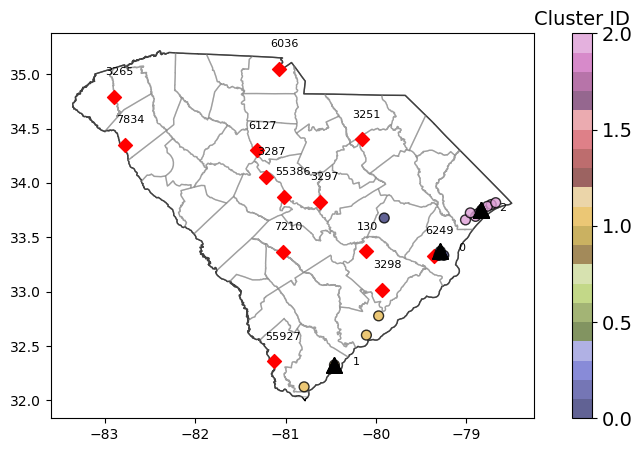

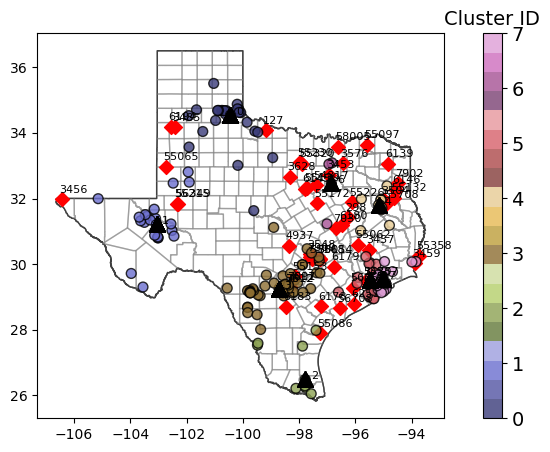

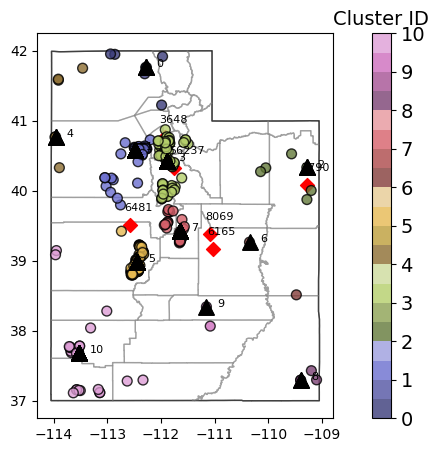

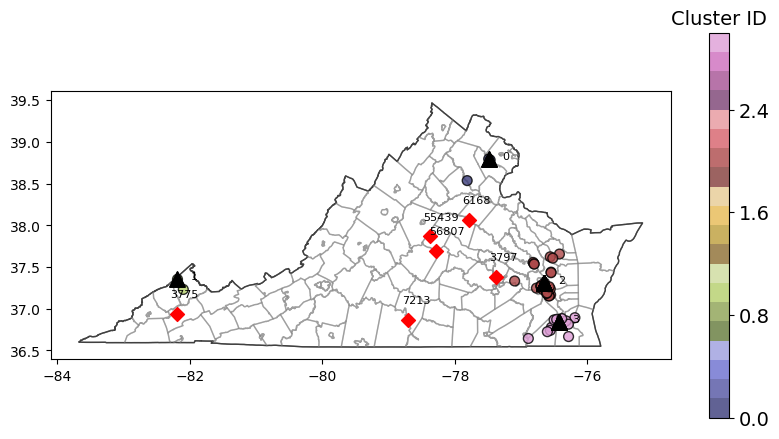

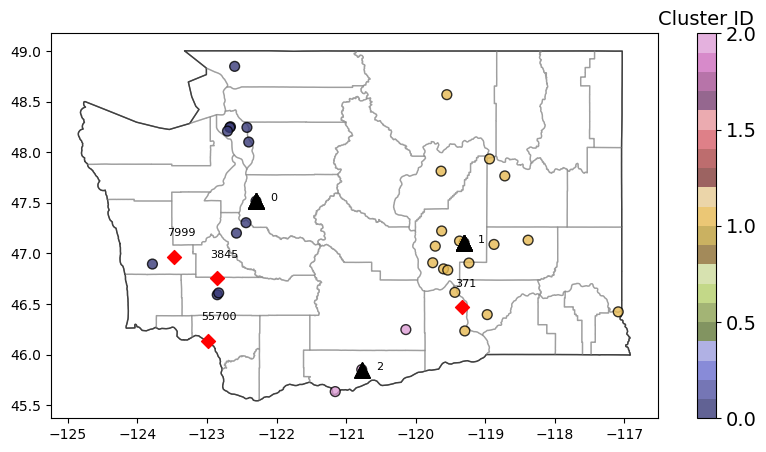

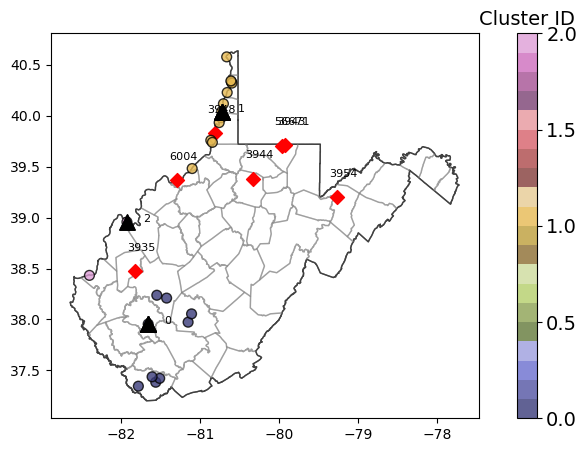

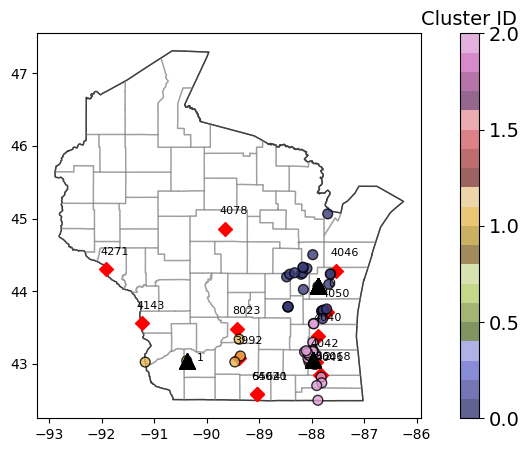

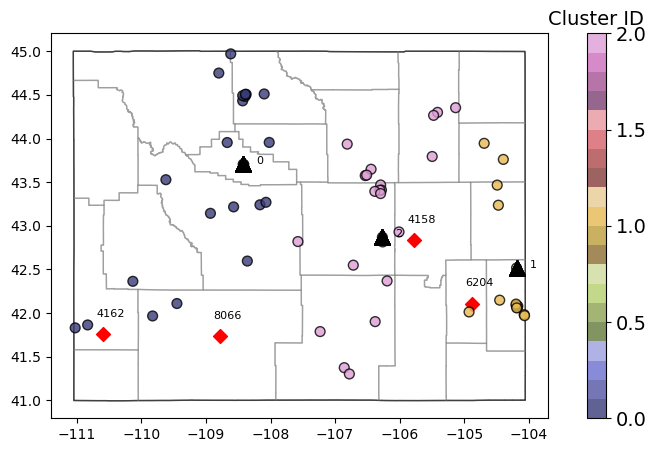

In [13]:
# Block to automate a run through all states
# No power data for SD
state_codes = ['AL','AZ','AR','CA','CO','CT','FL','GA','ID','IL', #10
               'IA','KS','KY','LA','MD','MI','MN','MS','MO',      #9
               'MT','NE','NV','NJ','NM','NY','NC','ND','OH',      #9
               'OK','OR','PA','SC','TX','UT','VA','WA',           #8
               'WV','WI','WY']                                    #3

odd_states = ['ME','IN','MA','NH','TN']                          #5 =44

for state_alpha in state_codes:
    print(state_alpha)
    # Read relevant files
    PATH = r'\Users\mhardika\Documents\AMO\Analysis Data Files\clustering_results\\' + state_alpha
    cluster_bw_df = pd.read_csv(PATH + '\\' + state_alpha.lower()+'_cluster.csv').drop(['Unnamed: 0'],axis=1)
    subcluster_bw_df = pd.read_csv(PATH + '\\' + state_alpha.lower()+'_subcluster.csv').drop(['Unnamed: 0'],axis=1)
    bw_cluster_kmeans = pd.read_csv(PATH + '\\' + state_alpha.lower()+'_bw_kmeans.csv').drop(['Unnamed: 0'],axis=1)
   
    fig = plot_map(cluster_bw_df)
    PATH = r'\Users\mhardika\Documents\AMO\Analysis Data Files\Power\\' + state_alpha + '\\'
    fig.savefig(PATH +  state_alpha.lower()+'_map.jpg')

    # For unclustered case
    one_pp_many_bw_df = state_pp_calc(state_alpha)

    # Check if folder already exists
    PATH = r'\Users\mhardika\Documents\AMO\Analysis Data Files\Power\\' + state_alpha
    if not os.path.exists(PATH):
        os.makedirs(PATH)

        
    name = '\pp_combined_unclustered_' + state_alpha.lower() +'.csv'
    # one_pp_many_bw_df.to_csv(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Power'+ name )
    one_pp_many_bw_df.to_csv(PATH + '\\'+ name )

    # For clustered case
    cols = ['State','PlantCode','PPLatitude','PPLongitude','PPDemand','BWSites','BWLatitude','BWLongitude','BWAvailable','Distance_km',
        'PPDemandFracMet','LCOW','TransportLCOW','tLCOW','WeightedtLCOW','Cum_PPDemandFracMet']

    one_pp_many_bw_cluster_df  = pd.DataFrame(columns=cols)

    one_pp_many_bw_cluster_df = state_pp_cluster_calc(state_alpha)

        # Check if folder already exists
    PATH = r'\Users\mhardika\Documents\AMO\Analysis Data Files\Power\\' + state_alpha
    if not os.path.exists(PATH):
        os.makedirs(PATH)

    name = '\pp_combined_clustered_' + state_alpha.lower()+'.csv'
    # one_pp_many_bw_cluster_df.to_csv(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Power'+ name )
    one_pp_many_bw_cluster_df.to_csv(PATH + '\\' + name )
        

In [831]:
# one_pp_many_bw_all_states_df.to_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Source to Use Scenarios/Brackish to Power/one_pp_many_bw_all_states_df_3.csv')

In [832]:
# one_pp_many_bw_all_states_df_read = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Source to Use Scenarios/Brackish to Power/one_pp_many_bw_all_states_df_3.csv').set_index('Unnamed: 0')
# one_pp_many_bw_all_states_df_read.index.names = ['PlantCode']
# one_pp_many_bw_all_states_df_read = one_pp_many_bw_all_states_df_read.drop('PlantCode',axis=1)

Box Plots

In [833]:
# one_pp_many_bw_all_states_df_plot = one_pp_many_bw_all_states_df[(one_pp_many_bw_all_states_df['Cum_PPDemandFracMet']<=1)].groupby('PlantCode').last()
# # one_pp_many_bw_all_states_df_plot = one_pp_many_bw_all_states_df_read.groupby('PlantCode').last()

In [834]:
# ax = one_pp_many_bw_all_states_df_plot.boxplot('Cum_PPDemandFracMet',by='State',figsize = (15,8))
# ax.set_title( 'Powerplant Sector',fontsize = 14)
# ax.set_ylabel('Demand Fraction Met',fontsize = 14)
# ax.set_xlabel('State',fontsize = 14)
# # ax.set_ylim([0,100])
# plt.yscale('log')
# plt.suptitle(' ')

In [835]:
# ax= one_pp_many_bw_all_states_df_plot.boxplot('WeightedtLCOW',by='State',figsize = (15,8))
# ax.set_title( 'Powerplant Sector',fontsize = 14)
# ax.set_ylabel('LCOW (\$/${m^3}$)',fontsize = 14)
# ax.set_xlabel('State',fontsize = 14)
# # ax.set_ylim([0,1.6])
# plt.suptitle(' ')

In [836]:
# max_LCOW = 1.6
# one_pp_many_bw_all_states_df_plot = one_pp_many_bw_all_states_df_read[(one_pp_many_bw_all_states_df_read['Cum_PPDemandFracMet']<=1) 
#                                         & (one_pp_many_bw_all_states_df_read['WeightedtLCOW']<=max_LCOW)].groupby('PlantCode').last()

# # one_pp_many_bw_all_states_df_plot = one_pp_many_bw_all_states_df_read[ (one_pp_many_bw_all_states_df_read['WeightedtLCOW']<=max_LCOW)].groupby('PlantCode').last()

In [837]:
# one_pp_many_bw_all_states_df_plot

In [838]:
# ax = one_pp_many_bw_all_states_df_plot.boxplot('Cum_PPDemandFracMet',by='State',figsize = (15,8))
# ax.set_title( 'Powerplant Sector',fontsize = 14)
# ax.set_ylabel('Demand Fraction Met',fontsize = 14)
# ax.set_xlabel('State',fontsize = 14)
# ax.set_ylim([0,1])
# # plt.yscale('log')
# plt.suptitle(' ')

In [839]:
# ax= one_pp_many_bw_all_states_df_plot.boxplot('WeightedtLCOW',by='State',figsize = (15,8))
# ax.set_title( 'Powerplant Sector',fontsize = 14)
# ax.set_ylabel('LCOW (\$/${m^3}$)',fontsize = 14)
# ax.set_xlabel('State',fontsize = 14)
# ax.set_ylim([0,1.6])
# plt.suptitle(' ')